Перед вами данные взаимодействий с рекламными объявлениями на некоторой площадке за 6 дней. И таблица с характеристиками рекламных клиентов (тех, кто разместил эти объявления).

# Задачи
1. Разберемся с распределением количества показов и кликов. Посчитайте среднее количество показов и среднее количество кликов на объявления за весь период (округлите до целых).
2. Нарисуйте график распределения показов на объявление за весь период.
3. Давайте посчитаем скользящее среднее показов с окном 2. Какое значение скользящего среднего получим за 6 апреля 2019 года (ответ округлите до целых)?
4. Скользящее среднее часто используется для поиска аномалий в данных. Давайте попробуем нанести на один график значения арифметического среднего по дням и скользящего среднего количества показов. В какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним? Дни, в которых скользящее среднее равно NaN, не учитываем. 
5. *Напишите функцию, которая найдет проблемное объявление (с наибольшим/наименьшим количеством показов) в день, в который была замечена самая большая по модулю аномалия. 
6. Теперь подгрузим данные по рекламным клиентам и найдем среднее количество дней от даты создания рекламного клиента и первым запуском рекламного объявления этим клиентом.
7. Вычислите конверсию из создания рекламного клиента в запуск первой рекламы в течение не более 365 дней. Ответ дайте в процентах и округлите до сотых. (Фильтровать нужно по значению в формате pd.Timedelta(365, unit='d'))
8. Давайте разобъем наших клиентов по промежуткам от создания до запуска рекламного объявления, равным 30. Определите, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования (от 0 до 30 дней). Список промежутков для метода pd.cut – [0, 30, 90, 180, 365]
9. А теперь – выведем на интерактивный график эти категории с количеством уникальных клиентов в них.

# Описание данных
**ads_data.csv** – данные взаимодействий с рекламными объявлениями

* date – дата
* time – время
* event – действие (просмотр/клик)
* platform – платформа
* ad_id – id объявления
* client_union_id – id рекламного кабинета
* campaign_union_id – id рекламной кампании
* ad_cost_type – тип оплаты
* ad_cost – цена
* has_video – есть ли видео
* target_audience_count – размер аудитории

**ads_clients_data.csv** – характеристики рекламных клиентов

* date – дата
* client_union_id – id рекламного кабинета
* community_id – id сообщества
* create_date – дата создания рекламного клиента

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

%matplotlib inline

In [7]:
import time
# from datetime import timedelta
# start_time = time.monotonic()

cli = pd.read_csv('data/ads_clients_data.csv', parse_dates=['date', 'create_date'])
ads = pd.read_csv('data/ads_data.csv', parse_dates=['date', 'time'])

# end_time = time.monotonic()
# print(timedelta(seconds=end_time - start_time))

0:00:01.703000


In [ ]:
ads.head()

In [17]:
ads.shape

(1000000, 11)

In [18]:
cli.shape

(122078, 4)

**1. Для начала посчитаем среднее количество разных рекламных событий (показы и клики) по объявлениям. Тонкий момент: помните, что некоторые показываемые объявления не кликались, и при группировке в таких случаях не будет строк с кликами, а для подсчёта среднего по объявлениям их нужно учитывать. Округлите ответы до целых чисел.**

Могут понадобиться:

* pivot()
* fillna()

In [20]:
ads.event.value_counts()

event
view     890822
click    109178
Name: count, dtype: int64

In [26]:
ads.ad_id.nunique()
#many views and clicks 
#not much id-s
#means one id has many views and clicks
#two classes of events + agg -> calls for pivot

965

In [24]:
ads.isna().sum()

date               0
client_union_id    0
community_id       0
create_date        0
dtype: int64

In [8]:
#ads.groupby('ad_id').event.value_counts()
ev_count=ads.groupby(['ad_id', 'event'], as_index=False).size()
ev_count

,ad_id,event,size
0,2,click,1
1,2,view,101
2,3,click,3
3,3,view,184
4,1902,click,1
...,...,...,...
1476,122013,view,156
1477,122023,view,68
1478,122031,click,1
1479,122031,view,138


In [9]:
ev_piv = ev_count.pivot(index='ad_id', columns='event', values='size') \
.fillna(0)
ev_piv

event,click,view
ad_id,,
2,1.0,101.0
3,3.0,184.0
1902,1.0,41.0
2064,0.0,35.0
2132,1.0,58.0
...,...,...
122004,4.0,100.0
122013,0.0,156.0
122023,0.0,68.0


In [47]:
ev_piv.mean()

event
click    113.137824
view     923.131606
dtype: float64

Среднее количество кликов на объявление **113**. Среднее количество показов на объявление **923**.

**2. Давайте посмотрим на распределение показов объявлений!**

* По оси x – число показов
* По оси y – доля объявлений с такими показами

**Прологарифмируйте число показов, а затем постройте такой график, чтобы можно было понять форму распределения. Выберите соответствующий график:**
![](https://ucarecdn.com/54b16d2c-b0e9-4900-acf6-1745d72108f1/-/crop/1001x569/55,42/-/preview/)

Для такого же отображения используйте эти настройки
```python
sns.set(
    font_scale=2,    
    style="whitegrid",    
    rc={'figure.figsize':(20,7)}    
        )
```

Могут пригодиться:

* sns.distplot
* np.log

F:\Users\123\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='view', ylabel='Count'>

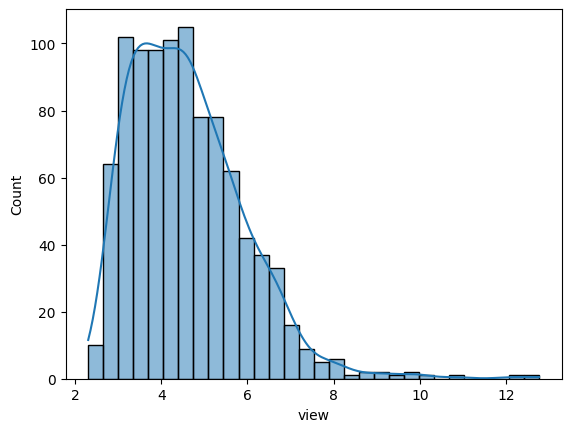

In [81]:
sns.histplot(np.log(ev_piv.view), kde=True)

<Axes: >

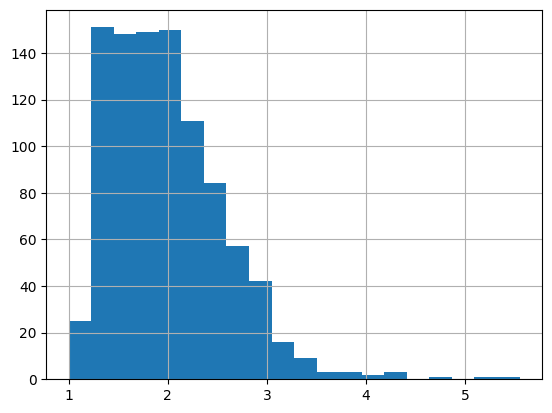

In [83]:
ev_piv.view.apply(np.log10) \
.replace(float("-inf"), float("NaN")).dropna() \
.hist(bins=20)

* **A**
* B
* C
* D

**3. Теперь нужно найти среднее количество показов на 1 объявление (ad_id) по дням, не учитывая объявления, у которых не было показов (обычное среднее). После этого посчитайте скользящее среднее по полученному результату с окном в 2 элемента.**

**Вопрос**: Какое значение скользящего среднего получим за 6 апреля 2019 года? Округлите ответ до целого числа.

Могут пригодиться:

* pivot()
* скользящее среднее

In [10]:
ads_day = ads[ads.event=='view'] \
.pivot_table(index='ad_id',
                           columns='date',
                           values='time', 
                           aggfunc='count')
# ads_day = ads.groupby(['ad_id', 'event'], as_index=False).size()
# ads_day = ads_day.rename(columns={"size": "sz"})
# ads_day_mean = ads_day.groupby(['date']).sz.mean()
# ads_day_mean.rolling(2).mean()
ads_day_mean  = ads_day.mean()
ads_day_mean

date
2019-04-01    154.482270
2019-04-02    137.786982
2019-04-03    163.952778
2019-04-04    675.901720
2019-04-05    919.109677
2019-04-06    277.122727
dtype: float64

In [14]:
ads_day_roll = ads_day_mean.rolling(2).mean().round(0)
ads_day_roll

date
2019-04-01      NaN
2019-04-02    146.0
2019-04-03    151.0
2019-04-04    420.0
2019-04-05    798.0
2019-04-06    598.0
dtype: float64

In [15]:
ads_day_roll['2019-04-06']

598.0

Ответ: `598`

**4. Скользящее среднее часто используется для поиска аномалий в данных. Давайте попробуем нанести на один график значения просто среднего количества показов по дням и скользящего среднего на основе этих данных (которое мы получили в прошлом задании).**

**Посчитайте, в какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним? Дни, в которых скользящее среднее равно NaN, не учитываем. Запишите ответ в формате yyyy-MM-dd**

Пример ответа:

`2020-12-31`

Могут пригодиться:

* sns.lineplot()
* скользящее среднее
* значение по модулю

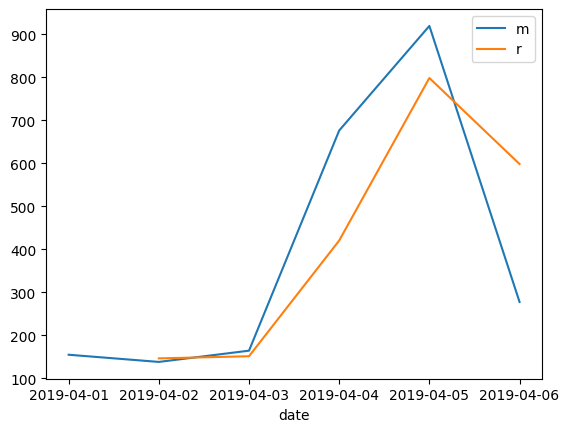

In [21]:
sns.lineplot(ads_day_mean, label='m')
sns.lineplot(ads_day_roll, label='r')

plt.legend()

In [33]:
str((abs(ads_day_mean[1:]-ads_day_roll[1:])) \
    .idxmax())[0:10]

'2019-04-06'

**5. Объедините данные рекламы с данными о рекламных клиентах и найдите среднее количество дней от даты создания рекламного клиента (create_date) и первым запуском рекламного объявления этим клиентом (date).**

**В качестве ответа укажите среднее число дней.**

In [38]:
cli_ads = pd.merge(cli, ads, on='client_union_id',
                  suffixes=("_cli", "_ads"))
cli_ads.head()

,date_cli,client_union_id,community_id,create_date,date_ads,time,event,platform,ad_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2020-05-07,1,-130371893,2018-12-24,2019-04-01,2019-04-01 00:08:51,view,android,3,1,CPC,46.7,0,45035
1,2020-05-07,1,-130371893,2018-12-24,2019-04-01,2019-04-01 00:09:36,view,ios,3,1,CPC,46.7,0,45035
2,2020-05-07,1,-130371893,2018-12-24,2019-04-01,2019-04-01 00:29:30,view,ios,3,1,CPC,46.7,0,45035
3,2020-05-07,1,-130371893,2018-12-24,2019-04-01,2019-04-01 00:29:58,view,android,3,1,CPC,46.7,0,45035
4,2020-05-07,1,-130371893,2018-12-24,2019-04-01,2019-04-01 00:51:54,view,android,3,1,CPC,46.7,0,45035


In [65]:
cli_ads['difference'] = (cli_ads.date_ads - 
 cli_ads.create_date)

In [102]:
diff_gp = cli_ads.groupby('client_union_id').difference.min() 
diff_gp.mean().days

124

Ответ: `124`

**6. 💀 Сложное задание! 💀**

**Давайте вычислим конверсию из создания рекламного кабинета в запуск первой рекламы в течение не более 365 дней.**

**Конверсия – отношение числа клиентов, которые совершили целевое действие (создали рекламу), к общему числу клиентов. Например, 1000 клиентов создали кабинет, но лишь 50 из них запустили рекламу. В таком случае конверсия будет равна**

50/1000 * 100 = 5%

**Чтобы отобрать данные за нужный промежуток, можно воспользоваться сравнением времени до создания первой рекламы с pd.Timedelta(365, unit='day'))**

**Ответ дайте в процентах и округлите до сотых. Пример ответа:**

34.69

In [97]:
(cli_ads.difference<=timedelta(days=365)).sum()
#нету больше 365

1000000

In [100]:
cli_ads.difference.max()

Timedelta('252 days 00:00:00')

In [101]:
(cli_ads.client_union_id.nunique()/
cli.client_union_id.nunique())*100

0.6864463703533806

Ответ: `0.69`

**7. Давайте разобъем наших клиентов по промежуткам от создания рекламного кабинета до запуска первого рекламного объявления.**

**Определите, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования (от 0 до 30 дней). Список промежутков дней для метода pd.cut() – [0, 30, 90, 180, 365]. Создать временные промежутки можно с помощью pd.to_timedelta().**

Могут пригодиться:

* pd.cut()
* value_counts()

In [112]:
px.bar(diff_cut) \
.update_xaxes(categoryorder="total ascending")diff_gp[diff_gp<=timedelta(days=30)]
#быстрее без pd.cut но ладно

client_union_id
2137     29 days
14606    29 days
21194    28 days
24853    28 days
27420    29 days
38094    28 days
98415    29 days
108678   26 days
110442   29 days
114880   30 days
116173   29 days
Name: difference, dtype: timedelta64[ns]

In [137]:
tdlist = \
[timedelta(days=x) for x in [0, 30, 90, 180, 365]]
labels = \
['0-30', '30-90', '90-180', '180-365']
#[str(x.days)+'-'+str(y.days) for x, y \
#in zip(tdlist[:-1], tdlist[1:])]
diff_cut = pd.cut(diff_gp, tdlist, labels=labels)
diff_cut

client_union_id
1         90-180
9         90-180
13         30-90
16        90-180
20         30-90
           ...  
122004     30-90
122013    90-180
122023    90-180
122031    90-180
122078     30-90
Name: difference, Length: 838, dtype: category
Categories (4, object): ['0-30' < '30-90' < '90-180' < '180-365']

In [143]:
diff_cut.value_counts()

difference
90-180     396
30-90      263
180-365    168
0-30        11
Name: count, dtype: int64

Ответ: `0-30 => 11`

**8. И последнее задание: постройте интерактивный барплот, на котором будут показаны категории с количеством уникальных клиентов в них (то, что у вас получилось на прошлом степе, по запуску первого рекламного объявления). Расположите их так, чтобы внизу была самая малочисленная, а наверху – самая большая.**

In [149]:
px.bar(diff_cut) \
.update_xaxes(categoryorder="total ascending")
#интерактивность графиков в том, что они не сохраняются?
#Plotly is a more sophisticated tool than Seaborn and Bokeh, and it is well-suited for creating interactive visualizations with its well-designed tooling and APIs

1. **от 90 до 180**
2. **от 30 до 90**
3. **от 180 до 365**
4. **от 0 до 30**